In [1]:
import re
import json
import uuid
from datetime import datetime
from typing import Annotated, List, Dict, Any, Literal, Optional
from typing_extensions import TypedDict
from pydantic import BaseModel, Field
from langchain_core.messages import HumanMessage, AIMessage
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain_ollama import ChatOllama
from langchain_ollama import OllamaEmbeddings
from langchain_chroma import Chroma
from langgraph.graph import StateGraph, END, START


In [2]:
llm = ChatOllama(model="qwen3:4b", temperature=0)
embeddings = OllamaEmbeddings(model="nomic-embed-text:v1.5")

In [3]:
call_stack = []

In [4]:
class StripThinkParser(StrOutputParser):
    """Remove <think>...</think> and surrounding whitespace."""
    
    def parse(self, text: str) -> str:
        # Remove <think>...</think> sections
        cleaned = re.sub(r"<think>.*?</think>", "", text, flags=re.DOTALL)
        # Also handle [think]...[/think] variations
        cleaned = re.sub(r"\[think\].*?\[/think\]", "", cleaned, flags=re.DOTALL)
        # Remove extra whitespace
        cleaned = re.sub(r"\n\s*\n", "\n\n", cleaned)
        call_stack.append(f"StripThinkParser.parse: Removed thinking tags from response")
        return cleaned.strip()

In [5]:
class MemoryMetadata(BaseModel):
    """Metadata for memory entries"""
    source: Literal["user_input", "agent_response", "external"] = Field(default="user_input")
    importance: Literal["high", "medium", "low"] = Field(default="medium")
    tags: List[str] = Field(default_factory=list)
    created_at: str = Field(default_factory=lambda: datetime.now().isoformat())

class MemoryEntry(BaseModel):
    """Structured memory entry"""
    id: str = Field(default_factory=lambda: str(uuid.uuid4()))
    content: str = Field(..., description="The memory content")
    type: Literal["fact", "preference", "experience", "interaction"] = Field(default="interaction")
    metadata: MemoryMetadata = Field(default_factory=MemoryMetadata)
    timestamp: str = Field(default_factory=lambda: datetime.now().isoformat())
 
class MemoryAgentState(TypedDict):
    messages: Annotated[List[Any], "Messages in the conversation"]
    user_input: str
    current_task: str
    memory_context: str
    retrieved_memories: str
    new_memories: List[MemoryEntry]
    final_response: str
    memory_operation: Literal["start", "retrieve", "integrate", "respond", "encode", "store", "end"]
    task_processed: bool  # New field to track if task has been processed


In [6]:
import os
os.environ["CHROMA_TELEMETRY_ENABLED"] = "false"
os.environ["ANONYMIZED_TELEMETRY"] = "False"
from chromadb.config import Settings
memory_store = Chroma(
    collection_name="agent_memory",
    embedding_function=embeddings,
    persist_directory="./memory_db"
)

Failed to send telemetry event ClientStartEvent: capture() takes 1 positional argument but 3 were given
Failed to send telemetry event ClientCreateCollectionEvent: capture() takes 1 positional argument but 3 were given


In [7]:
# Memory Encoder Node (Fixed)
def memory_encoder_node(state: MemoryAgentState) -> Dict[str, Any]:
    """Encodes new information into memory format"""
    call_stack.append("memory_encoder_node: Encoding new information")
    
    prompt = ChatPromptTemplate.from_messages([
        ("system", """You are a Memory Encoding Specialist.
        Your task is to identify important information from the interaction that should be stored in memory.
        Extract key facts, user preferences, important decisions, and learning experiences.
        
        Format your response as a JSON array of memory entries:
        [
          {{
            "content": "Important information to remember",
            "type": "fact|preference|experience|interaction",
            "metadata": {{
              "source": "user_input|agent_response|external",
              "importance": "high|medium|low",
              "tags": ["tag1", "tag2"]
            }}
          }}
        ]
        
        Focus on information that would be valuable for future interactions.
        Use <think> tags for your analysis process."""),
        ("user", "User Input: {user_input}\nAgent Response: {response}")
    ])
    
    # Get the last agent response if available
    agent_response = ""
    for msg in reversed(state["messages"]):
        if isinstance(msg, AIMessage):
            agent_response = msg.content
            break
    
    chain = prompt | llm | StripThinkParser()
    memory_suggestion = chain.invoke({
        "user_input": state["user_input"],
        "response": agent_response
    })
    
    # Try to parse as JSON, fallback to simple text if parsing fails
    new_memories = []
    try:
        memory_data = json.loads(memory_suggestion)
        if isinstance(memory_data, list):
            for item in memory_data:
                if isinstance(item, dict) and "content" in item:
                    # Validate and create MemoryEntry with Pydantic
                    memory_entry = MemoryEntry(
                        content=item["content"],
                        type=item.get("type", "interaction"),
                        metadata=MemoryMetadata(
                            source=item.get("metadata", {}).get("source", "user_input"),
                            importance=item.get("metadata", {}).get("importance", "medium"),
                            tags=item.get("metadata", {}).get("tags", [])
                        )
                    )
                    new_memories.append(memory_entry)
    except Exception as e:
        call_stack.append(f"memory_encoder_node: JSON parsing failed - {str(e)}")
        # If JSON parsing fails, create a simple memory entry
        memory_entry = MemoryEntry(
            content=memory_suggestion,
            type="interaction",
            metadata=MemoryMetadata(source="user_input", importance="medium")
        )
        new_memories.append(memory_entry)
    
    call_stack.append(f"memory_encoder_node: Encoded {len(new_memories)} memory entries")
    
    return {
        "new_memories": new_memories,
        "memory_operation": "store"
    }

In [8]:
def memory_storage_node(state: MemoryAgentState) -> Dict[str, Any]:
    """Stores encoded memories in persistent storage"""
    call_stack.append("memory_storage_node: Storing memories")
    
    stored_count = 0
    texts_to_store = []
    metadatas_to_store = []
    ids_to_store = []
    
    for memory_entry in state["new_memories"]:
        # Convert Pydantic model to dict for storage
        if isinstance(memory_entry, MemoryEntry):
            texts_to_store.append(memory_entry.content)
            metadatas_to_store.append({
                "id": memory_entry.id,
                "type": memory_entry.type,
                "timestamp": memory_entry.timestamp,
                "metadata": memory_entry.metadata.model_dump_json(),
                "tags": ",".join(memory_entry.metadata.tags)
            })
            ids_to_store.append(memory_entry.id)
            stored_count += 1
    
    # Add to Chroma vector store if we have memories to store
    if texts_to_store:
        memory_store.add_texts(
            texts=texts_to_store,
            metadatas=metadatas_to_store,
            ids=ids_to_store
        )
    
    call_stack.append(f"memory_storage_node: Stored {stored_count} memories")
    
    # After storing memories, we're done with this interaction
    return {
        "memory_operation": "end"
    }


In [9]:
def memory_retrieval_node(state: MemoryAgentState) -> Dict[str, Any]:
    """Retrieves relevant memories based on current context"""
    call_stack.append("memory_retrieval_node: Retrieving relevant memories")
    
    # Combine current task with recent messages for context
    retrieval_context = f"Current task: {state['current_task']}\n"
    # Add recent conversation context
    recent_messages = state["messages"][-3:] if len(state["messages"]) >= 3 else state["messages"]
    for msg in recent_messages:
        if isinstance(msg, HumanMessage):
            retrieval_context += f"User: {msg.content}\n"
        elif isinstance(msg, AIMessage):
            retrieval_context += f"Agent: {msg.content}\n"
    
    # Retrieve relevant memories
    retriever = memory_store.as_retriever(search_kwargs={"k": 5})
    retrieved_docs = retriever.invoke(retrieval_context)
    
    # Format retrieved memories
    retrieved_memories = "\n".join([doc.page_content for doc in retrieved_docs])
    
    call_stack.append(f"memory_retrieval_node: Retrieved {len(retrieved_docs)} memories")
    
    return {
        "retrieved_memories": retrieved_memories,
        "memory_operation": "integrate"
    }


In [10]:
def memory_integration_node(state: MemoryAgentState) -> Dict[str, Any]:
    """Integrates retrieved memories into the current context"""
    call_stack.append("memory_integration_node: Integrating memories with context")
    
    # Create enriched context with memories
    memory_context = f"Retrieved relevant memories:\n{state['retrieved_memories']}\n\n"
    memory_context += f"Current task: {state['current_task']}"
    
    call_stack.append("memory_integration_node: Memory context prepared")
    
    return {
        "memory_context": memory_context,
        "memory_operation": "respond"
    }


In [11]:
def response_generation_node(state: MemoryAgentState) -> Dict[str, Any]:
    """Generates response using integrated memory context"""
    call_stack.append("response_generation_node: Generating memory-augmented response")
    
    prompt = ChatPromptTemplate.from_messages([
        ("system", """You are a Memory-Augmented AI Assistant.
        You have access to relevant memories from past interactions that can help inform your response.
        Use these memories to provide more personalized, context-aware, and consistent responses.
        
        Relevant Past Information:
        {memory_context}
        
        Provide a helpful response to the user's request.
        Reference relevant past information when appropriate.
        Use <think> tags for your reasoning process."""),
        ("user", "{user_input}")
    ])
    
    chain = prompt | llm | StripThinkParser()
    response = chain.invoke({
        "memory_context": state.get("memory_context", "No relevant memories found."),
        "user_input": state["user_input"]
    })
    
    call_stack.append("response_generation_node: Response generated")
    
    return {
        "final_response": response,
        "memory_operation": "encode"  # After responding, encode the interaction
    }

In [12]:
def memory_router(state: MemoryAgentState) -> str:
    """Route to the appropriate memory operation"""
    call_stack.append(f"memory_router: Routing to {state['memory_operation']}")
    return state["memory_operation"]


In [13]:
builder = StateGraph(MemoryAgentState)

# Add nodes
builder.add_node("retrieve", memory_retrieval_node)
builder.add_node("integrate", memory_integration_node)
builder.add_node("respond", response_generation_node)
builder.add_node("encode", memory_encoder_node)
builder.add_node("store", memory_storage_node)

# Add edges in a linear flow
builder.add_edge(START, "retrieve")
builder.add_edge("retrieve", "integrate")
builder.add_edge("integrate", "respond")
builder.add_edge("respond", "encode")
builder.add_edge("encode", "store")
builder.add_conditional_edges(
    "store",
    memory_router,
    {
        "end": END
    }
)

# Compile the graph
memory_augmented_agent = builder.compile()

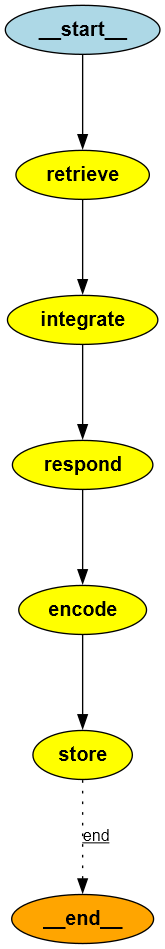

In [14]:
from IPython.display import Image, display
display(Image(memory_augmented_agent.get_graph().draw_png()))

In [15]:
def run_memory_augmented_agent(user_input: str, current_task: str = "") -> Dict[str, Any]:
    """Run the memory-augmented agent with user input"""
    # Clear call stack for new execution
    global call_stack
    call_stack = []
    call_stack.append("run_memory_augmented_agent: Starting execution")
    
    initial_state = MemoryAgentState(
        messages=[HumanMessage(content=user_input)],
        user_input=user_input,
        current_task=current_task,
        memory_context="",
        retrieved_memories="",
        new_memories=[],  # This will be a list of MemoryEntry objects
        final_response="",
        memory_operation="start",
        task_processed=False
    )
    
    # Run the graph with a higher recursion limit to be safe
    result = memory_augmented_agent.invoke(initial_state, {"recursion_limit": 50})
    
    # Format the output for clarity
    output = {
        "user_input": user_input,
        "current_task": current_task,
        "agent_response": result["final_response"],
        "execution_trace": call_stack.copy(),
        "memory_stats": {
            "total_memories": memory_store._collection.count(),
        }
    }
    
    call_stack.append("run_memory_augmented_agent: Execution completed")
    return output

In [16]:
# Conversation Manager for multi-turn interactions (Fixed)
class MemoryAugmentedConversation:
    def __init__(self):
        self.conversation_history = []
        self.current_task = ""
    
    def chat(self, user_input: str) -> Dict[str, Any]:
        """Handle a conversation turn with memory augmentation"""
        # Add to conversation history
        self.conversation_history.append({"role": "user", "content": user_input})
        
        # Run the memory-augmented agent
        result = run_memory_augmented_agent(user_input, self.current_task)
        
        # Add agent response to history
        self.conversation_history.append({"role": "assistant", "content": result["agent_response"]})
        
        # Update current task if mentioned (case-insensitive with regex)
        task_match = re.search(r"[Tt]ask\s*[:：]\s*(.+)", user_input)
        if task_match:
            self.current_task = task_match.group(1).strip()
        
        return result
    
    def set_task(self, task: str):
        """Set the current task context"""
        self.current_task = task
    
    def get_history(self) -> List[Dict[str, str]]:
        """Get conversation history"""
        return self.conversation_history.copy()

In [17]:
print("=== Memory-Augmented Agent Demo (with Pydantic) ===\n")
    
# Initialize conversation
conversation = MemoryAugmentedConversation()

# Turn 1: User introduces themselves and mentions preferences
print("User: Hi, I'm Sid. I'm interested in learning about renewable energy, particularly solar power.")
result1 = conversation.chat("Hi, I'm Sid. I'm interested in learning about renewable energy, particularly solar power.")
print(f"Agent: {result1['agent_response']}")
print("\nExecution Trace:")
for step in result1['execution_trace'][-3:]:  # Show last 3 steps
    print(f"  - {step}")
print(f"Memory Store: {result1['memory_stats']['total_memories']} entries")

print("\n" + "-"*50 + "\n")

=== Memory-Augmented Agent Demo (with Pydantic) ===

User: Hi, I'm Sid. I'm interested in learning about renewable energy, particularly solar power.


Failed to send telemetry event CollectionQueryEvent: capture() takes 1 positional argument but 3 were given


Agent: Hello Sid! It's great to hear your interest in renewable energy, especially solar power. Let me share some key insights to help you get started:

### **What is Solar Power?**  
Solar power harnesses energy from the sun using technologies like **photovoltaic (PV) panels** (which convert sunlight directly into electricity) or **solar thermal systems** (which use the sun’s heat for heating or power). The sun provides enough energy in one hour to meet global energy demands for an entire year!

### **How Solar Works**  
1. **Photovoltaic Panels**: Made of semiconductor materials (like silicon), they absorb sunlight and release electrons, creating an electric current.  
2. **Solar Thermal Systems**: Use mirrors or lenses to concentrate sunlight, generating heat for water heating or steam turbines.  

### **Types of Solar Technology**  
- **Monocrystalline Silicon**: Most efficient, high cost.  
- **Polycrystalline Silicon**: Slightly less efficient, more affordable.  
- **Thin-Film So

In [18]:
# Turn 2: User asks a specific question
print("User: What are the main advantages of solar power over fossil fuels?")
result2 = conversation.chat("What are the main advantages of solar power over fossil fuels?")
print(f"Agent: {result2['agent_response']}")
print("\nExecution Trace:")
for step in result2['execution_trace'][-3:]:  # Show last 3 steps
    print(f"  - {step}")
print(f"Memory Store: {result2['memory_stats']['total_memories']} entries")

print("\n" + "-"*50 + "\n")



Number of requested results 5 is greater than number of elements in index 2, updating n_results = 2


User: What are the main advantages of solar power over fossil fuels?
Agent: </think>

The main advantages of solar power over fossil fuels include:  

1. **Renewable and Sustainable**: Solar energy harnesses the sun's power, a virtually inexhaustible resource, unlike fossil fuels, which are finite and deplete over time.  
2. **Zero Greenhouse Gas Emissions**: Solar panels generate electricity without emitting carbon dioxide or other pollutants, helping mitigate climate change. Fossil fuels, however, release significant amounts of CO₂ and other harmful gases during extraction and combustion.  
3. **Low Operational Costs**: Once installed, solar systems require minimal maintenance and have decreasing costs over time. Fossil fuels depend on extraction, transportation, and processing, which are expensive and environmentally damaging.  
4. **Decentralized Energy Production**: Solar panels can be installed at individual or community levels, reducing reliance on centralized power grids. This 

In [19]:
# Turn 3: User with a task
print("User: Task: Help me create a presentation outline about solar energy for my environmental science class.")
result3 = conversation.chat("Task: Help me create a presentation outline about solar energy for my environmental science class.")
print(f"Agent: {result3['agent_response']}")
print("\nExecution Trace:")
for step in result3['execution_trace'][-3:]:  # Show last 3 steps
    print(f"  - {step}")
print(f"Memory Store: {result3['memory_stats']['total_memories']} entries")

print("\n" + "-"*50 + "\n")

Number of requested results 5 is greater than number of elements in index 3, updating n_results = 3


User: Task: Help me create a presentation outline about solar energy for my environmental science class.
Agent: </think>

Here’s a structured presentation outline tailored to your interest in solar energy and its advantages over fossil fuels:

---

### **Title:**  
**"Solar Power: A Sustainable Solution for the Future"**

---

### **1. Introduction**  
- **Definition of Solar Energy**: Explain how solar energy is harnessed from the sun using photovoltaic (PV) panels or concentrated solar power (CSP).  
- **Relevance**: Link solar energy to environmental science by emphasizing its role in combating climate change and reducing reliance on fossil fuels.  
- **Objective**: Highlight the goal of the presentation: to compare solar power with fossil fuels and showcase why solar is a better choice.  

---

### **2. Environmental Benefits of Solar Power**  
- **Reduction of Greenhouse Gases**: Compare carbon dioxide emissions from solar vs. fossil fuels.  
- **Clean Energy**: Discuss zero air p

In [20]:
# Turn 4: Follow-up question that should use memory
print("User: Based on what we discussed, what would be good visual aids for the presentation?")
result4 = conversation.chat("Based on what we discussed, what would be good visual aids for the presentation?")
print(f"Agent: {result4['agent_response']}")
print("\nExecution Trace:")
for step in result4['execution_trace'][-3:]:  # Show last 3 steps
    print(f"  - {step}")
print(f"Memory Store: {result4['memory_stats']['total_memories']} entries")

print("\n" + "="*60 + "\n")

# Show conversation history
print("Conversation History:")
for msg in conversation.get_history():
    role = "User" if msg["role"] == "user" else "Agent"
    print(f"{role}: {msg['content'][:100]}{'...' if len(msg['content']) > 100 else ''}")

User: Based on what we discussed, what would be good visual aids for the presentation?
Agent: Here’s a thoughtfully curated list of visual aids tailored to your presentation on solar energy, leveraging the key points we discussed (environmental benefits, cost-effectiveness, sustainability, and technological advancements):

---

### **1. Comparative Infographics**  
- **Solar vs. Fossil Fuels**: A side-by-side comparison highlighting:  
  - **Environmental Impact**: Carbon emissions, water usage, and land degradation.  
  - **Cost**: Initial investment vs. long-term savings.  
  - **Sustainability**: Renewable vs. finite resources.  
  - **Technology**: Diagrams of solar panels vs. coal plants.  

---

### **2. Lifecycle Diagram**  
- **Solar Panel Lifecycle**: A flowchart showing:  
  - Manufacturing (silicon production, panel assembly).  
  - Installation (residential vs. utility-scale).  
  - Energy production (photovoltaic effect).  
  - End-of-life recycling (e-waste management).  